## Prologue
$\texttt{Universe-render}$ is a mini package to render hydro sim output into images and movies.

This tutorial will introduce the basic components of the package and the workflow on movie creation.

### Download data

First of all, let's download the data for visualization. 

__You can make your own dataset files from the raw simulation outputs or snapshots!__

In [1]:
import os
import warnings
warnings.simplefilter('ignore')

if not os.path.exists("../data"):
    os.mkdir("../data")
    
#os.system("wget some_url") # idk how to public a dataset for such purpose!

Now you already have a copy of particle data from a certain hydro simulation at `../data/example_data.npy`.

The npy data is preprocessed to reduce the file size. It contains 6 columns, they are: 


|      `x`       |      `y`       |      `z`       |      `temp`       |               `rho`                |     `hsml`     |
| :------------: | :------------: | :------------: | :---------------: | :--------------------------------: | :------------: |
| $\mathrm{kpc}$ | $\mathrm{kpc}$ | $\mathrm{kpc}$ | $\mathrm{Kelvin}$ | $\mathrm{10^{10}h^2M_\odot/kpc^3}$ | $\mathrm{kpc}$ |

We have a function to read this dataset, `snap_io.from_npy`. This function automatically parse the columns and convert them into groups of data.

__You can make your own dataset files from the raw simulation outputs or snapshots!__

In [2]:
from universe_render import snap_io
pos, hsml, rho, temp = snap_io.from_npy("../data/example_data.npy")

### Cameras
You cannot shot any photo without a camera. In $\texttt{universe_render}$, we implement a `Camera` class to handle the view. Most of the notation here follows that in OpenGL, for which you can find a good tutorial [here](https://learnopengl.com/Getting-started/Camera). 

Let's start by creating a Camera object:

In [3]:
import numpy as np
from universe_render import camera

In [4]:
pos_cam = np.array([500000, 500000, 500000]) # position of the camera, unit should the same as above
dir_cam = np.array([1, 0, 0]) # direction of the camera, NOTE THIS IS OPPOSITE in OpenGL

cam = camera.Camera(pos_cam, dir_cam, zNear = 100, zFar= 20000)

A camera is primarily determined by its position and its direction. Additional parameter are `up` (up-axis), `fov` (Field-of-View in degree), `zNear` and `zFar` (the nearest and farthest z-distance to render). For more information, please check the docstring of `camera.Camera`.

The `camera.Camera` class contains methods to get the position and hsml (i.e., "size") of particles from the perspective of the camera. An example of the view matrix and project matrix is shown below:

In [5]:
print("The view matrix (aka look at matrix) of this camera is:")
print(cam.look_at_matrix())

print("The project matrix of this camera is:")
print(cam.project_matrix_from_fov())

The view matrix (aka look at matrix) of this camera is:
[[ 0.e+00 -1.e+00  0.e+00  5.e+05]
 [ 0.e+00  0.e+00  1.e+00 -5.e+05]
 [-1.e+00  0.e+00  0.e+00  5.e+05]
 [ 0.e+00  0.e+00  0.e+00  1.e+00]]
The project matrix of this camera is:
[[   1.            0.            0.            0.        ]
 [   0.            1.            0.            0.        ]
 [   0.            0.           -1.01005025 -201.00502513]
 [   0.            0.           -1.            0.        ]]


We also provide a simple wrapper function, `camera.raw_to_clip`, to convert the input particle configration to the position and hsml in camera's clip space. 

In [6]:
npix_x = 1920 # width of canvas in pixels
npix_y = 1080 # height of canvas in pixles
w, h, p = camera.raw_to_clip(cam, rho, hsml, pos, npix_x, npix_y)
# w=weight, h=hsml, p=position

### Render of a Single Image
We are going to render one image now. To begin with, we will translate the particles from clip space to the canvas:

In [7]:
from universe_render.camera import clip_to_canvas
hi, pi = clip_to_canvas(h, p, npix_x, npix_y)

Then we will render the image onto a ndarray with the size of (npix_x=800, npix_y=600). 

A simple and straightforward implementation is (we will add some magic later!):

In [8]:
from universe_render.render import dist
from universe_render.sph_kernels import cubic_spline_2D as sph_kernel

def render(w, h, p, npix_x, npix_y):
    nx, ny = npix_x, npix_y
    npart = w.size
    grid = np.zeros((npix_x, npix_y))
    for ip in range(npart):
        ix_start, ix_end = int(max(0, p[ip,0] - 2*h[ip])), int(min(nx, p[ip,0] + 2*h[ip]))
        iy_start, iy_end = int(max(0, p[ip,1] - 2*h[ip])), int(min(ny, p[ip,1] + 2*h[ip]))
        for ix in range(ix_start, ix_end):
            for iy in range(iy_start, iy_end):
                r = dist(p[ip,0], p[ip,1], ix, iy)
                grid[ix, iy] = sph_kernel(r, h[ip])*w[ip] + grid[ix, iy]
    return grid

You may notice that we import 2 functions from $\texttt{universe_render}$, `dist` and `cubic_spline_2D`.
The former one is simplely an implementation of distance in 2D, while the second one is the "shape" of SPH particles, i.e., how the density or other quantites vary as the distance to particle center changes.

Try it out and you will find it running super slow.

In [9]:
# super slow!
grid = render(w, hi, pi, npix_x, npix_y)


KeyboardInterrupt



Now we have no choice but mixing some magic ingredient: `numba`

In [10]:
from universe_render.render import dist
from universe_render.sph_kernels import cubic_spline_2D as sph_kernel
from numba import njit

@njit
def render(w, h, p, npix_x, npix_y):
    nx, ny = npix_x, npix_y
    npart = w.size
    grid = np.zeros((npix_x, npix_y))
    for ip in range(npart):
        ix_start, ix_end = int(max(0, p[ip,0] - 2*h[ip])), int(min(nx, p[ip,0] + 2*h[ip]))
        iy_start, iy_end = int(max(0, p[ip,1] - 2*h[ip])), int(min(ny, p[ip,1] + 2*h[ip]))
        for ix in range(ix_start, ix_end):
            for iy in range(iy_start, iy_end):
                r = dist(p[ip,0], p[ip,1], ix, iy)
                grid[ix, iy] = sph_kernel(r, h[ip])*w[ip] + grid[ix, iy]
    return grid

This time it will be faster (but still take minutes!)

In [11]:
# will be faster but plz be patient; it may take ~1 min
import time
t = time.time()
grid = render(w, hi, pi, npix_x, npix_y)
print(f"time elpased: {time.time() - t:.2f} s")

time elpased: 67.04 s


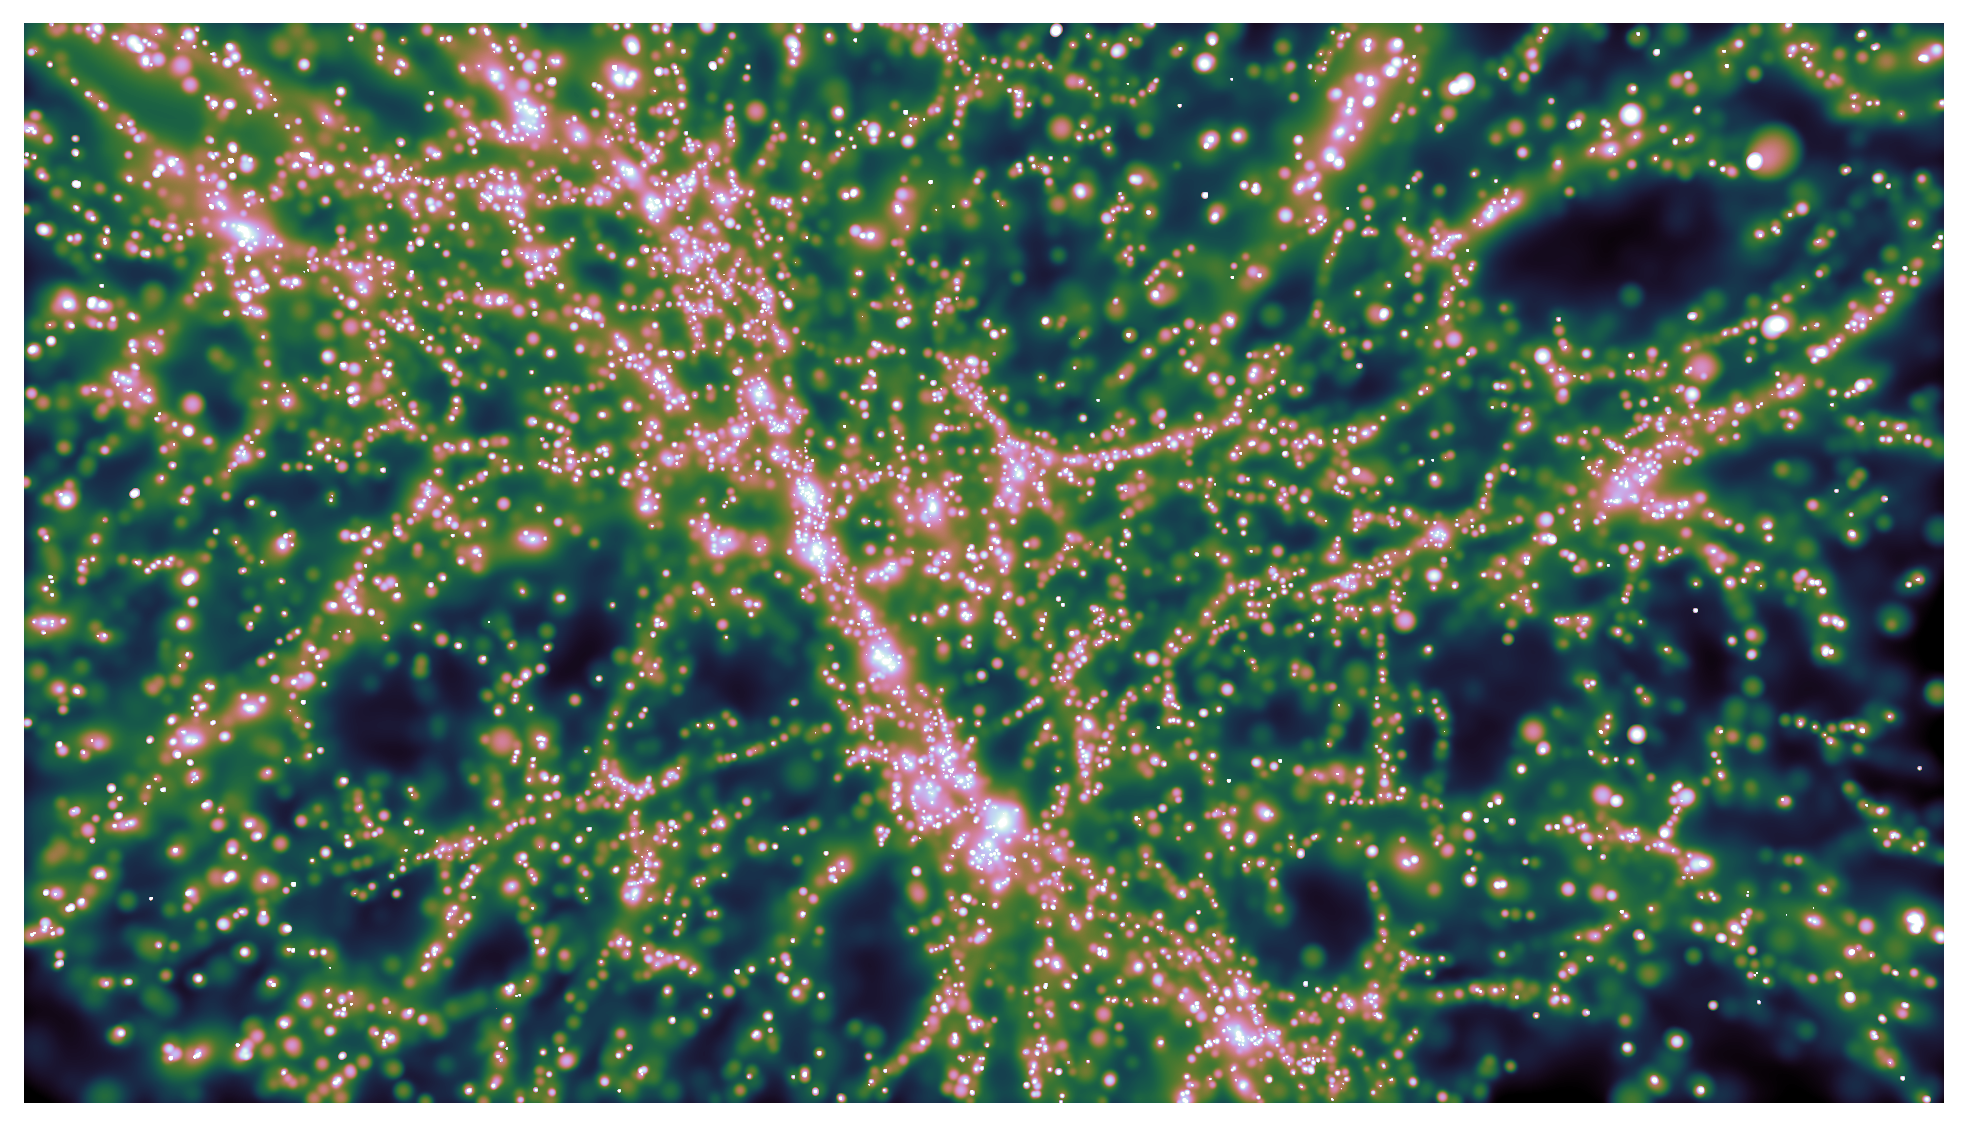

In [12]:
import matplotlib.pyplot as plt
dpi=240
fig = plt.figure(figsize=(grid.shape[0]/dpi, grid.shape[1]/dpi), dpi=dpi)
axes=fig.add_axes([0,0,1,1])    
plt.imshow(np.log10(grid).T, cmap="cubehelix", origin='lower',clim=(-9, -4))
axes.set_axis_off()

### Frames
Now we have know how to create single image using $\texttt{universe_render}$. How about movies, i.e., a continuous set of images (aka __frames__)? We also provide a way to define the frames in $\texttt{universe_render}$, and more importantly, read / write frames, and interpolate among the frames.
#### create your own frame(s)
One frame is represented with a numpy array in this package. Our first example of frame corresponds to the camera for rendering the image above:

In [13]:
# t, posx, posy, posz, dirx, diry, dirz, fov, n, f
frame_cam = np.array([0, 500000, 500000, 500000, 1, 0, 0, 90, 100, 20000])

This frame array just include all the information needed in the camera. You can convert the frame into an camera object with frames.

In [14]:
from universe_render.frames import frame_to_camera
cam_ = frame_to_camera(frame_cam)

Multiple frames bring you multiple cameras, so that you can make movies! Let's create a set of frames where the camera flies around the center of massive structure:

*One special tip for the `t_arr`: this is used to determine the time order of the frames and determine the number of interpolation. The exact spacing of `t_arr` will not enter the final movie.

In [15]:
central_pos = np.array([500000, 500000, 500000]) # central coordinate of the simulation box
rot_radius = 10000 # set the rotation radius to 10000 kpc
n_frames = 10 # number of frames
angle_arr = np.arange(n_frames) / n_frames * 2 * np.pi 
t_arr = np.expand_dims(np.arange(n_frames), axis=1)
pos_arr = np.array([np.cos(angle_arr), np.sin(angle_arr), np.zeros(n_frames)]).T * rot_radius + central_pos
dir_arr = -np.array([np.cos(angle_arr), np.sin(angle_arr), np.zeros(n_frames)]).T
fov_arr = np.ones((n_frames, 1)) * 90 # FOV = 90 deg for all the frames
zNear_arr = np.ones((n_frames, 1)) * 100 # zNear = 100 kpc for all the frames
zFar_arr = np.ones((n_frames, 1)) * 20000 # zFar = 20000 kpc for all the frames

frames = np.hstack([t_arr, pos_arr, dir_arr, fov_arr, zNear_arr, zFar_arr])

Then we have a list of frames to play with: you can covert it into cameras one by one, write it into files, and read it when you need!

In [16]:
# convert the frames into cameras
cam_list = [frame_to_camera(frame) for frame in frames]
print("list of cameras: ", cam_list)

# write/read the frames into files
from universe_render.frames import read_frame_file, write_frame_file
write_frame_file(frames, "frames.txt")
frames_ = read_frame_file("frames.txt")

list of cameras:  [<universe_render.camera.Camera object at 0x2adec4be7370>, <universe_render.camera.Camera object at 0x2adec4be73d0>, <universe_render.camera.Camera object at 0x2adebf460070>, <universe_render.camera.Camera object at 0x2adec4be7760>, <universe_render.camera.Camera object at 0x2adebf4504f0>, <universe_render.camera.Camera object at 0x2adebf4500d0>, <universe_render.camera.Camera object at 0x2adebf4507c0>, <universe_render.camera.Camera object at 0x2adebf4505e0>, <universe_render.camera.Camera object at 0x2adebf450190>, <universe_render.camera.Camera object at 0x2adec4be7070>]


Here's a visualization of cameras' configuration on x-y plane:

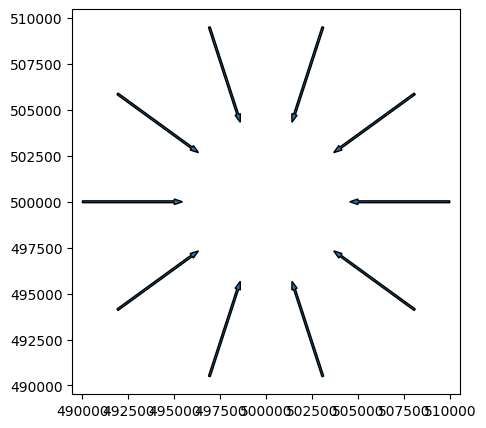

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for frame in frames:
    x , y  = frame[1], frame[2]
    dx, dy = frame[4], frame[5]
    plt.axis("equal")
    plt.arrow(x, y, dx*5000, dy*5000, width=100)
plt.show()

You may feel the number of frame is still limited. To achieve more frame from given "key" frames, you can call the following function:

In [18]:
from universe_render.frames import keyframes_to_all_frames, interp_rot

from scipy.interpolate import interp1d
# frame interpolation

all_frames = keyframes_to_all_frames(frames, timestep=0.1, loop=True, kind='cubic')

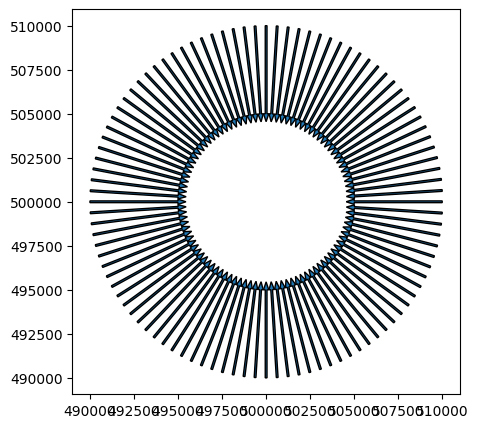

In [19]:
plt.figure(figsize=(5, 5))
for frame in all_frames:
    x , y  = frame[1], frame[2]
    dx, dy = frame[4], frame[5]
    plt.axis("equal")
    plt.arrow(x, y, dx*5000, dy*5000, width=100)
plt.show()

Now you can save this denser one for the real movie!

In [20]:
write_frame_file(all_frames, "all_frames.txt")

## TODO
### mpi parallel